# Statistiken

Zum Schluss macht sich Julia an den letzten Baustein des Fallbeispiels: **die statistische Auswertung** der NO₂-Messwerte.

Ziel ist eine tabellarische Übersicht *ähnlich zu* `pandas.describe()` – aber ohne Pandas (also ohne externe Bibliotheken): Anzahl, Mittelwert, Standardabweichung, Minimum/Maximum sowie Quartile (25 %, Median, 75 %).

In [1]:
def _non_empty_lines(text):
    return [ln.strip() for ln in text.strip().splitlines() if ln.strip()]


def _ensure_comma_delimiter(lines):
    """
    Zwischenlösung: Wir unterstützen NUR Komma.
    Wenn es nach Semikolon aussieht, geben wir eine klare Fehlermeldung.
    """
    if not lines:
        raise ValueError("CSV ist leer.")

    first_line = lines[0]
    if "," not in first_line and ";" in first_line:
        raise ValueError(
            "Unerwartetes Trennzeichen ';'. Dieser Parser erwartet Komma ',' als Trennzeichen."
        )


def _parse_header(header_line):
    header = [h.strip() for h in header_line.split(",")]
    if not header or header[0] != "datetime":
        raise ValueError(
            "Ungültiger Header: erste Spalte muss 'datetime' heißen (Komma ',' als Trennzeichen)."
        )
    stations = header[1:]
    if not stations:
        raise ValueError("Header enthält keine Stationsspalten.")
    return header, stations


def _parse_no2_value(value, station, line):
    """
    Parsen eines einzelnen Messwerts.

    - Leere Felder geben wir als None zurück (d.h. Messwert fehlt).
    - Nicht-leere Felder müssen in float umwandelbar sein.
    """
    value = value.strip()
    if value == "":
        return None
    try:
        return float(value)
    except ValueError as e:
        raise ValueError(
            f"Ungültiger Messwert {value!r} für {station!r} in Zeile: {line!r}."
        ) from e


def parse_air_quality_csv_v3(csv_text):
    lines = _non_empty_lines(csv_text)
    _ensure_comma_delimiter(lines)

    header, stations = _parse_header(lines[0])
    result = {s: {"time": [], "no2": []} for s in stations}

    for line in lines[1:]:
        if "," not in line and ";" in line:
            raise ValueError(
                "Unerwartetes Trennzeichen ';' in den Datenzeilen. Dieser Parser erwartet Komma ','."
            )

        parts = [p.strip() for p in line.split(",")]
        if len(parts) > len(header):
            raise ValueError(
                f"Zu viele Spalten in Zeile: {line!r} (erwartet {len(header)}, gefunden {len(parts)})."
            )
        if len(parts) < len(header):
            parts = parts + [""] * (len(header) - len(parts))

        t = parts[0]
        for idx, station in enumerate(stations, start=1):
            parsed = _parse_no2_value(parts[idx], station, line)
            if parsed is None:
                continue
            result[station]["time"].append(t)
            result[station]["no2"].append(parsed)

    return result

## Daten einlesen

Wie in den vorherigen Teilkapiteln liest Julia die CSV-Datei direkt aus dem Internet ein. Dafür reicht `urllib` aus der Standardbibliothek – es muss nichts installiert werden.

In [2]:
from urllib.request import urlopen

url = "https://raw.githubusercontent.com/pandas-dev/pandas/main/doc/data/air_quality_no2.csv"
with urlopen(url) as response:
    csv_text = response.read().decode("utf-8")

data = parse_air_quality_csv_v3(csv_text)


Damit die Ausgabe später hübscher aussieht, entfernt Julia noch das Präfix `station_` aus den Stationsnamen (wie schon im Histogramm-Kapitel).

In [3]:
data = {k.replace("station_", "").title(): v for k, v in data.items()}
sorted(data.keys())

['Antwerp', 'London', 'Paris']

Zur Erinnerung: Die Daten liegen als Dictionary vor, pro Station jeweils die Zeitstempel und die NO₂-Werte.

Wenn Julia kurz prüfen möchte, ob alles passt, gibt sie eine kleine Vorschau aus (statt das komplette Dictionary in den Text zu kopieren).

In [4]:
import json

def preview_data(data, n=5):
    return {
        station: {"time": d["time"][:n], "no2": d["no2"][:n], "total": len(d["no2"])}
        for station, d in data.items()
    }

print(json.dumps(preview_data(data, n=5), indent=2, ensure_ascii=False))

{
  "Antwerp": {
    "time": [
      "2019-05-07 03:00:00",
      "2019-05-07 04:00:00",
      "2019-05-08 03:00:00",
      "2019-05-08 04:00:00",
      "2019-05-09 03:00:00"
    ],
    "no2": [
      50.5,
      45.0,
      23.0,
      20.5,
      20.0
    ],
    "total": 95
  },
  "Paris": {
    "time": [
      "2019-05-07 03:00:00",
      "2019-05-07 04:00:00",
      "2019-05-07 05:00:00",
      "2019-05-07 06:00:00",
      "2019-05-07 07:00:00"
    ],
    "no2": [
      25.0,
      27.7,
      50.4,
      61.9,
      72.4
    ],
    "total": 1004
  },
  "London": {
    "time": [
      "2019-05-07 02:00:00",
      "2019-05-07 03:00:00",
      "2019-05-07 04:00:00",
      "2019-05-07 05:00:00",
      "2019-05-07 07:00:00"
    ],
    "no2": [
      23.0,
      19.0,
      19.0,
      16.0,
      26.0
    ],
    "total": 969
  }
}


## Quantile
Julia startet mit der Berechnung der Quantile. Grundsätzlich teilen Quantile eine (aufsteigend) **sortierte** Zahlenliste in Abschnitte.

- **25 %-Quantil (Q1)**: 25 % der Werte liegen links davon (oder sind kleiner/gleich).
- **50 %-Quantil (Median)**: „mittlerer“ Wert (bzw. bei gerader Anzahl der Mittelwert der zwei mittleren Werte).
- **75 %-Quantil (Q3)**: 75 % der Werte liegen links davon.

**Beispiel**

Wir haben 10 Werte:
```text
82, 91, 12, 92, 63, 9, 28, 55, 96, 97
```

Wir sortieren sie:
```text
9, 12, 28, 55, 63, 82, 91, 92, 96, 97
```


**25 %-Quantil (Q1)**

25% heißt: „Ein Viertel der Werte soll links davon liegen.“
In unserem Zahlenbeispiel mit 10 Zahlenwerten, wäre das der 2,5. Wert. Den gibt es aber leider nicht. Also was sollen wir tun? Julia entscheidet sich einfach die Zahl an der 3. Position zu nehmen. In der Literatur ist diese Verfahren, bei dem also die nächst höhere Position verwendet wird, als Nearest-Rank-Verfahren bekannt. Es gibt auch andere Strategien.

```text
9, 12, [28], 55, 63, 82, 91, 92, 96, 97
```
In unserem Beispiel ist das 25 %-Quantil = 28.


```{admonition} Hinweis
:class: remark

Es gibt verschiedene Quantil-Definitionen. Je nach Definition bekommt man auch andere Ergebnisse. Die Idee der Nearest-Rank-Definition ist:
- Idee: „Es gibt keine halbe Position – wir nehmen den nächsten sinnvollen Messwert.“
- Regel: Nimm das **kleinste Element**, bei dem „mindestens \(q\) %“ erreicht sind.
Im Zweifel: fragen Sie immer nach, mit welchem Verfahren die Ergebnisse bestimmt wurden.
```


**50 %-Quantil (Median)**

50 % heißt: „Die Hälfte der Werte liegt links, die Hälfte rechts.“
Bei 10 Werten gibt es keinen einzelnen mittleren Wert, sondern zwei in der Mitte.

```text
9, 12, 28, 55, [63, 82], 91, 92, 96, 97
```

Der Median liegt zwischen diesen beiden:
(63 + 82) / 2 = 72,5

In unserem Beispiel ist das 50 %-Quantil (Median) = 72,5.

**75 %-Quantil (Q3)**

75 % heißt: „Drei Viertel der Werte sollen links davon liegen.“
Drei Viertel von 10 sind 7,5 Werte → Nearest-Rank nimmt den nächsten ganzen Rang: \(k = \lceil 0{,}75 \cdot 10 \rceil = 8\).

```text
9, 12, 28, 55, 63, 82, 91, [92], 96, 97
```

In unserem Beispiel ist das 75 %-Quantil = 92.

## Ermittlung der Quantile

Julia zerlegt die Ermittlung der Quantile in zwei Teilaufgaben:

- Sortieren der Messwerte (aufsteigend)
- Berechnung der Quantilwerte (wie im Beispiel gezeigt)

Julia startet zunächst einmal damit die Messwerte sortieren. Sie ist ganz Feuer und Flamme, da sie im Studium viel über Sortieralgorithmen gelernt hat.

Sie erinnert sich noch dass es zum Sortieren unterschiedliche Algorithmen gibt und findet eine Übersichtstabelle:

| Algorithmus / Familie | Kurzidee | Best Case | Average Case | Worst Case | Extra Space | Stabil | In-place | Praxis / Bemerkung |
|----------------------|----------|-----------|--------------|------------|-------------|--------|----------|--------------------|
| Bubble Sort | Tauscht benachbarte Elemente | O(n) | O(n²) | O(n²) | O(1) | Ja | Ja | Lehrzwecke |
| Selection Sort | Wählt jeweils Minimum | O(n²) | O(n²) | O(n²) | O(1) | Nein | Ja | Minimaler Speicher |
| Insertion Sort | Fügt Elemente in sortierte Teilliste ein | O(n) | O(n²) | O(n²) | O(1) | Ja | Ja | Kleine / fast sortierte Daten |
| Merge Sort | Divide & Conquer + Merge | O(n log n) | O(n log n) | O(n log n) | O(n) | Ja | Nein | Stabile Referenz |
| Quick Sort | Partition um Pivot | O(n log n) | O(n log n) | O(n²) | O(log n) | Nein | Ja | Sehr schnell, aber Worst-Case |
| Heap Sort | Heap-Struktur | O(n log n) | O(n log n) | O(n log n) | O(1) | Nein | Ja | Garantierte Laufzeit |
| Counting Sort | Zählt Vorkommen | O(n+k) | O(n+k) | O(n+k) | O(k) | Ja | Nein | Kleine Wertebereiche |
| Radix Sort | Ziffernweise Sortierung | O(n·k) | O(n·k) | O(n·k) | O(n+k) | Ja | Nein | Ganzzahlen / Strings |
| Timsort (Familie) | Adaptive Merge + Insertion | O(n) | O(n log n) | O(n log n) | O(n) | Ja | Nein | Industriestandard |
| PowerSort (Merge-Policy) | Nahezu optimale Merge-Reihenfolge | O(n) | O(n log n) | O(n log n) | O(n) | Ja | Nein | CPython ≥ 3.11 |




Sie recherchiert weiter und findet heraus: Python sortiert Listen seit Jahren mit einer sehr ausgefeilten, stabilen Merge-Sort-Familie (Timsort). Ab Python 3.11 wurde vor allem die *Merge-Strategie* verbessert (PowerSort). 

Julia würde trotzdem gerne selbst bestimmen können, welcher Algorithmus verwendet wird. Also implementiert sie ein kleines Strategie-Pattern: „Sortieren“ ist austauschbar – der Rest des Programms bleibt gleich.

In [5]:
from dataclasses import dataclass

class SortStrategy:
    def sort(self, values):
        raise NotImplementedError


@dataclass(frozen=True)
class BubbleSort(SortStrategy):
    def sort(self, values):
        a = list(values)  # kopieren, Input nicht verändern
        n = len(a)
        for i in range(n):
            swapped = False
            for j in range(0, n - i - 1):
                if a[j] > a[j + 1]:
                    a[j], a[j + 1] = a[j + 1], a[j]
                    swapped = True
            if not swapped:
                break
        return a


@dataclass(frozen=True)
class SelectionSort(SortStrategy):
    def sort(self, values):
        a = list(values)
        n = len(a)
        for i in range(n):
            min_idx = i
            for j in range(i + 1, n):
                if a[j] < a[min_idx]:
                    min_idx = j
            if min_idx != i:
                a[i], a[min_idx] = a[min_idx], a[i]
        return a


@dataclass(frozen=True)
class PythonSort(SortStrategy):
    def sort(self, values):
        return sorted(values)

Mini-Demo: Alle Strategien liefern dasselbe Ergebnis.

In [6]:
values = [82, 91, 12, 92, 63, 9, 28, 55, 96, 97]

strategies = [BubbleSort(), SelectionSort(), PythonSort()]
for s in strategies:
    print(type(s).__name__, "->", s.sort(values))

BubbleSort -> [9, 12, 28, 55, 63, 82, 91, 92, 96, 97]
SelectionSort -> [9, 12, 28, 55, 63, 82, 91, 92, 96, 97]
PythonSort -> [9, 12, 28, 55, 63, 82, 91, 92, 96, 97]


## Performance: Lernalgorithmen vs. Python-Sort

Julia muss sich entscheiden, welchen Algorithmus sie jetzt verwendet. Deshalb führt sie einen einfachen Performance-Test durch.


```{admonition} Exkurs: Performance messen (Profiling)
:class: tip
„Performance“ kann sich auf verschiedene Dinge beziehen – z.B. **Laufzeit**, **Speicherverbrauch (RAM)** oder **I/O-Verhalten** (Warten auf Dateien/Netzwerk). Welche Kennzahl relevant ist, hängt vom Programm ab.

**Einfache Zeitmessung in Python**

Die Idee ist folgende:
- wir messen den startzeitpunkt: start = time.perf_counter()   # alternativ: time.time()
- wir messen endzeitpunkt: endzeitpunkt = time.perf_counter()
Die Dauer ist dann entsprechend: dauer = endteitpunkt - start


**Profiling**
Profiling ist mehr als eine einzelne Zeitmessung: Es hilft Ihnen zu verstehen, **welche Funktionen** wie viel Zeit (oder Speicher) verbrauchen – also **wo** der Engpass wirklich liegt. 

- **CPU-Profiling (Standardbibliothek)**: `cProfile` (+ Auswertung mit `pstats`)
- **Visualisierung**: z.B. `snakeviz` (zeigt `cProfile`-Ausgaben grafisch)
- **Sampling-Profiler (geringer Overhead)**: z.B. `py-spy` (läuft auch an laufenden Prozessen)
- **Line-by-line**: z.B. `line_profiler` (sehr konkret, aber mehr Overhead)
- **Speicher/Allokationen**: `tracemalloc` (Standardbibliothek), optional `memory_profiler`

Tipp: Messen Sie mit **realistischen Eingaben** und achten Sie darauf, ob Ihr Programm eher **CPU-bound** (Rechnung) oder **I/O-bound** (Warten) ist.
```

Der Performance-Test ist so aufgebaut, dass jeder Algorithmus 100 mal getestet wird. Dann werden die Ergebnisse in einem boxplot gegeübergestellt.

```{admonition} Hinweis
::class: remark

Für die Darstellung verwenden wir `seaborn`. Das ist eine externe Bibliothek. Julia findet das hier in Ordnung, weil der Performance-Test nur der Analyse dient und nicht Teil der ausgelieferten Software ist.
```

Station: Paris | Größe n=1004


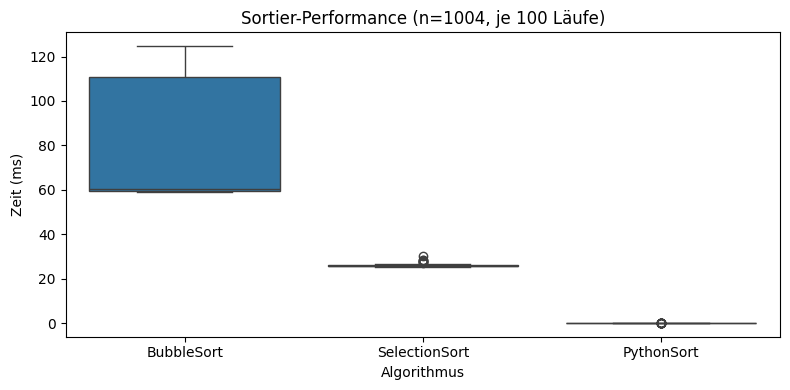

In [7]:
import time
import matplotlib.pyplot as plt
import seaborn as sns

def time_sort_once(strategy, values):
    # Achtung: Listen sind mutable -> jede Messung auf einer frischen Kopie
    sample = list(values)
    t0 = time.perf_counter()
    strategy.sort(sample)
    return time.perf_counter() - t0

# Reale Messdaten: wir vergleichen auf der Station Paris.
paris_no2 = data["Paris"]["no2"]

strategies = [BubbleSort(), SelectionSort(), PythonSort()]

print(f"Station: Paris | Größe n={len(paris_no2)}")

# 100 Messungen pro Algorithmus
n_runs = 100
names = []
times_ms = []

for s in strategies:
    name = type(s).__name__
    for _ in range(n_runs):
        dt = time_sort_once(s, paris_no2)
        names.append(name)
        times_ms.append(dt * 1000)

plt.figure(figsize=(8, 4))

sns.boxplot(x=names, y=times_ms)
plt.title(f"Sortier-Performance (n={len(paris_no2)}, je {n_runs} Läufe)")
plt.xlabel("Algorithmus")
plt.ylabel("Zeit (ms)")
plt.tight_layout()
plt.show()

```{exercise} Aufgabe
:label: exercise-sample

Implementieren Sie einen weiteren Sortieralgorithmus selbst und fügen Sie ihn dem Performance-Test hinzu. Visualisieren den Algorithmus mithilfe eines Struktogramms.
```



```{admonition} Wichtig
:class: warning

Sortieralgorithmen können prüfungsrelevant sein. Sie müssen die Algorithmen nicht alle lernen, aber Sie sollten in der Lage sein, mindestens einen Algorithmus selbstständig (also **ohne** `list.sort()` oder `sorted()`) zu implementieren.
```

Julia entscheidet sich: Für reale Daten nutzt sie die Python-Implementierung (schnell, getestet, robust). Ihre Implementierungen behält sie - vielleicht sind diese ja später noch irgendwann nutzbar.





## Standardbibliothek `statistics`

Dann kommt plötzlich Julias Kollegin vorbei und meint, dass sie bereits sehr gute Erfahrung mit der Python-Bibliothek `statistics` gemacht hat - auch eine native Bib. Die Bibliothek liefert nicht nur Mittelwerte und Standardabweichung sondern auch schon Quantile. Das ganze Sortieren, das Julia bereits angefangen hat, war also gar nicht notwendig.

Julia ärgert sich ein wenig, dass sie nicht ordentlich rechechiert hat und entscheidet sich die Bibliothek zu nutzen - damit muss sie auch keine Tests implementieren, was ja auch noch ausstehen würde.

In [8]:
import statistics as st

def describe(values):
    """
    Ähnlich zu pandas.describe(), aber:
    - ohne externe Bibliotheken
    - Quartile über `statistics.quantiles(...)` (Nearest-Rank war oben nur ein didaktisches Beispiel)
    """
    if not values:
        raise ValueError("Leere Liste.")

    # quantiles(...) gibt für n=4 drei Werte zurück: [25%, 50%, 75%]
    # Wir verwenden "inclusive", damit es auch für kleinere Listen definiert ist.
    q25, q50, q75 = st.quantiles(values, n=4, method="inclusive")
    sv = sorted(values)  # nur für min/max (ohne Input zu verändern)

    return {
        "count": len(values),
        "mean": st.mean(values),
        "std": st.stdev(values) if len(values) >= 2 else 0.0,
        "min": sv[0],
        "25%": q25,
        "50%": q50,
        "75%": q75,
        "max": sv[-1],
    }


def print_table(table_data, cols, precision=2):
    header = ["stat"] + cols
    rows = []

    for stat, values in table_data.items():
        row = [stat] + [
            f"{v:.{precision}f}" if isinstance(v, float) else str(v)
            for v in values
        ]
        rows.append(row)

    col_widths = [
        max(len(str(cell)) for cell in column)
        for column in zip(header, *rows)
    ]

    def fmt_row(row):
        return "  ".join(cell.ljust(w) for cell, w in zip(row, col_widths))

    print(fmt_row(header))
    print("-" * (sum(col_widths) + 2 * (len(col_widths) - 1)))
    for row in rows:
        print(fmt_row(row))


results_dict = []
cols = []

for station in data:
    result = describe(data[station]["no2"])
    cols.append(station)
    results_dict.append(result)

table = {k: [row[k] for row in results_dict] for k in results_dict[0]}
print_table(table, cols=cols)

stat   Antwerp  Paris  London
-----------------------------
count  95       1004   969   
mean   25.78    27.74  24.78 
std    12.68    15.29  11.21 
min    7.50     0.00   0.00  
25%    16.75    16.50  19.00 
50%    23.00    24.15  25.00 
75%    34.50    35.92  31.00 
max    74.50    97.00  97.00 
